In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [64]:

def find_project_root(markers=("pyproject.toml", ".git")) -> Path:
    """
    Descobre a raiz do projeto subindo diretórios até encontrar um marcador.

    Parâmetros:
        markers: nomes de arquivos/pastas que indicam a raiz (ex.: "pyproject.toml", ".git").

    Retorna:
        pathlib.Path apontando para a raiz do projeto, ou o diretório atual como fallback.
    """
    p = Path.cwd().resolve()
    for parent in [p, *p.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    return p

ROOT = find_project_root()

In [65]:
# MODEL_SAVE_PATH = 'modelo_ocr_simbolos.keras'
DATA_DIR = ROOT / "data"
MODEL_SAVE_PATH = DATA_DIR / "processed" / "modelo_ocr_simbolos.keras"
CLASS_NAMES_PATH = DATA_DIR / "raw" / "class_names.json"
DATASET_DIR = DATA_DIR / "raw" / "dataset"


In [66]:
# Verificar se class_names.json está na ordem correta (alfabética)
import json

with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
    loaded_classes = json.load(f)

# class_names do dataset de treino (ordem usada pelo modelo)
train_dir = os.path.join(DATASET_DIR, 'train')
train_classes_sorted = sorted(os.listdir(train_dir))

print("Verificando consistência de class_names...")
if loaded_classes == train_classes_sorted:
    print("✓ class_names.json está correto e consistente com o treinamento")
else:
    print("✗ ERRO: class_names.json difere da ordem do treinamento!")
    print(f"  Esperado (train): {train_classes_sorted[:5]}...")
    print(f"  Carregado (json): {loaded_classes[:5]}...")
    print("\nRECOMENDAÇÃO: Regere class_names.json com:")
    print("  import json")
    print("  with open(CLASS_NAMES_PATH, 'w', encoding='utf-8') as f:")
    print("      json.dump(sorted(os.listdir('dataset/train')), f, ensure_ascii=False)")

Verificando consistência de class_names...
✓ class_names.json está correto e consistente com o treinamento


In [67]:
# Carrega os nomes das classes a partir do arquivo 'class_names.json'
import json
with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
    class_names = json.load(f)
print(f"Nomes das classes carregados: {len(class_names)} classes.")

for idx, name in enumerate(class_names):
    print(idx, name)

Nomes das classes carregados: 146 classes.
0 U+0020
1 U+0021
2 U+0022
3 U+0023
4 U+0024
5 U+0025
6 U+0026
7 U+0027
8 U+0028
9 U+0029
10 U+002A
11 U+002B
12 U+002C
13 U+002D
14 U+002E
15 U+002F
16 U+0030
17 U+0031
18 U+0032
19 U+0033
20 U+0034
21 U+0035
22 U+0036
23 U+0037
24 U+0038
25 U+0039
26 U+003A
27 U+003B
28 U+003C
29 U+003E
30 U+003F
31 U+0040
32 U+0041
33 U+0042
34 U+0043
35 U+0044
36 U+0045
37 U+0046
38 U+0047
39 U+0048
40 U+0049
41 U+004A
42 U+004B
43 U+004C
44 U+004D
45 U+004E
46 U+004F
47 U+0050
48 U+0051
49 U+0052
50 U+0053
51 U+0054
52 U+0055
53 U+0056
54 U+0057
55 U+0058
56 U+0059
57 U+005A
58 U+005C
59 U+005F
60 U+0061
61 U+0062
62 U+0063
63 U+0064
64 U+0065
65 U+0066
66 U+0067
67 U+0068
68 U+0069
69 U+006A
70 U+006B
71 U+006C
72 U+006D
73 U+006E
74 U+006F
75 U+0070
76 U+0071
77 U+0072
78 U+0073
79 U+0074
80 U+0075
81 U+0076
82 U+0077
83 U+0078
84 U+0079
85 U+007A
86 U+00A2
87 U+00A3
88 U+00A7
89 U+00A8
90 U+00AC
91 U+00B0
92 U+00B2
93 U+00B3
94 U+00B7
95 U+00B9
96 U+00

In [72]:
import re

def parse_uplus(s: str) -> int:
    """
    Converte 'U+0044' (ou '0x0044', '0044') para inteiro do codepoint (ex.: 0x0044 -> 68).
    """
    m = re.fullmatch(r'(?:U\+|0x)?([0-9A-Fa-f]+)', s.strip())
    if not m:
        raise ValueError(f"Formato inválido: {s}")
    return int(m.group(1), 16)

def uplus_to_hex(s: str) -> str:
    """
    Converte 'U+0044' -> '0x0044' (sem deslocamento).
    """
    cp = parse_uplus(s)
    return f"0x{cp:04X}"

def uplus_to_index_int(s: str, base: int = 0x0020) -> int:
    """
    Converte 'U+0044' para índice inteiro relativo à base (p/ indexar lista class_names).
    Ex.: base 0x0020 (inclui espaço) -> 0x0044 - 0x0020 = 0x0024 (36).
         base 0x0021 (ignora espaço) -> 0x0044 - 0x0021 = 0x0023 (35).
    """
    cp = parse_uplus(s)
    idx = cp - base
    if idx < 0:
        raise ValueError(f"Índice negativo: codepoint 0x{cp:04X} antes da base 0x{base:04X}")
    return idx

def uplus_to_index_hex(s: str, base: int = 0x0020) -> str:
    """
    Igual ao anterior, mas retorna string em hexa: '0xYYYY'.
    """
    idx = uplus_to_index_int(s, base=base)
    return f"0x{idx:04X}"

# Exemplos:
# uplus_to_hex('U+0044')               -> '0x0044'
# uplus_to_index_hex('U+0044', 0x0020) -> '0x0024'  (inclui espaço)
# uplus_to_index_hex('U+0044', 0x0021) -> '0x0023'  (ignora espaço, corresponde ao seu exemplo)

In [ ]:

# DATASET_DIR = 'dataset'
IMG_HEIGHT = 64
IMG_WIDTH = 64

SYMBOL_UNICODE = 'U+0044'  # Exemplo: 'U+0044' para 'D'

SYMBOL_INDEX = uplus_to_index_int(SYMBOL_UNICODE, base=0x0021)


Modelo carregado para teste de previsão.


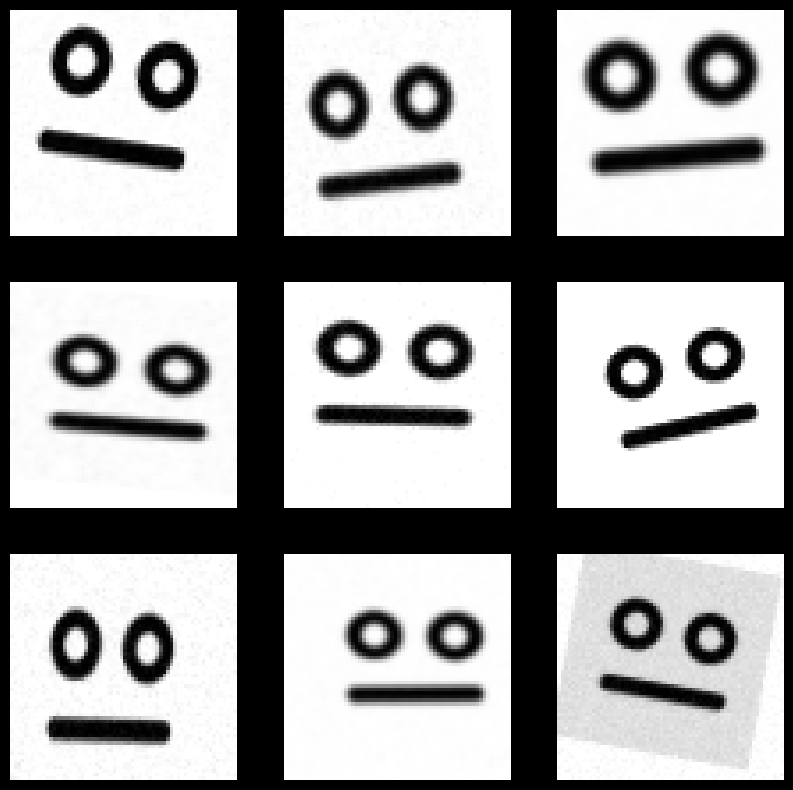

In [74]:
'''Teste rápido de previsão'''

# Carrega o modelo salvo
model = tf.keras.models.load_model(MODEL_SAVE_PATH)
print("\nModelo carregado para teste de previsão.")

# Carrega uma imagem de teste
test_image_path = os.path.join(DATASET_DIR, 'test', class_names[SYMBOL_INDEX])

# Exibe algumas imagens de teste
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_path = os.path.join(test_image_path, os.listdir(test_image_path)[i])
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
plt.show()


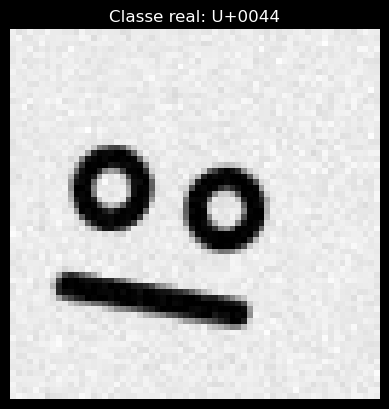

In [75]:
# Selecionar e exibir imagem de teste
sample_idx = 20
sample_image_path = os.path.join(test_image_path, os.listdir(test_image_path)[sample_idx])
sample_image = tf.keras.preprocessing.image.load_img(
    sample_image_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale'
)
plt.imshow(sample_image, cmap='gray')
plt.title(f"Classe real: {class_names[SYMBOL_INDEX]}")
plt.axis('off')
plt.show()


In [76]:
# CORREÇÃO: Preparar imagem para previsão (SEM normalização manual)
input_arr = tf.keras.preprocessing.image.img_to_array(sample_image)
# garantir shape correto (H, W, 1)
if input_arr.ndim == 2:
    input_arr = np.expand_dims(input_arr, axis=-1)
# adicionar dimensão do batch: (1, H, W, 1)
input_arr = np.expand_dims(input_arr, axis=0)

# IMPORTANTE: NÃO dividir por 255 aqui — o modelo já tem Rescaling(1./255) interno
# Se você dividir aqui, os valores ficarão 0..1/255 (muito pequenos)

predictions = model.predict(input_arr)
predicted_idx = np.argmax(predictions)
predicted_class = class_names[predicted_idx]
confidence = predictions[0][predicted_idx]

print(f"Classe real (pasta): {class_names[43]}")
print(f"Classe prevista: {predicted_class}")
print(f"Confiança: {confidence:.4f}")
print(f"\nTop-5 previsões:")
top5_idx = np.argsort(predictions[0])[-5:][::-1]
for i, idx in enumerate(top5_idx):
    print(f"  {i+1}. {class_names[idx]}: {predictions[0][idx]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Classe real (pasta): U+004C
Classe prevista: U+0044
Confiança: 1.0000

Top-5 previsões:
  1. U+0044: 1.0000
  2. U+002E: 0.0000
  3. U+00A7: 0.0000
  4. U+00F3: 0.0000
  5. U+0032: 0.0000
